In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [12]:
import tensorflow as tf


In [13]:
batch_size = 50
img_height = 50
img_width = 50

In [14]:
ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size50_cleaned/UShape"
no_ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size50_cleaned/NoUshape"

In [15]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.path)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)



print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3822


In [16]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_total = fill_df_with_label(ushapes_spectrograms, "ushape").append(fill_df_with_label(no_ushape_spectrograms, "noshape"))


df_train, df_val = train_test_split(dataframe_total, random_state = 101, test_size=0.25)

In [17]:
import scipy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(50, 50),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(50, 50),
)

Found 2992 validated image filenames belonging to 2 classes.
Found 998 validated image filenames belonging to 2 classes.


In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [19]:
#num_classes = len(class_names)
model = Sequential([
  #data_augmentation,
  layers.Input(shape=(50, 50, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)       

In [21]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


In [22]:
epochs = 50
history = model.fit_generator(generator=
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

c:\y\HARP_3_7\venv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
94/94 [==============================] - 496s 5s/step - loss: 0.1512 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2868.0000 - fn: 124.0000 - accuracy: 0.9586 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7773 - prc: 0.1253 - val_loss: 0.1551 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 954.0000 - val_fn: 44.0000 - val_accuracy: 0.9559 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7933 - val_prc: 0.1787
Epoch 2/50
94/94 [==============================] - 462s 5s/step - loss: 0.1458 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2868.0000 - fn: 124.0000 - accuracy: 0.9586 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8092 - prc: 0.1454 - val_loss: 0.1570 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 954.0000 - val_fn: 44.0000 - val_accuracy: 0.9559 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8218 - val_prc: 0.1915
Epoch 3/50
94/94 [==============================] - 471s 5s/step - loss: 0.1406 - tp: 0.0000e+00 - fp: 0.0

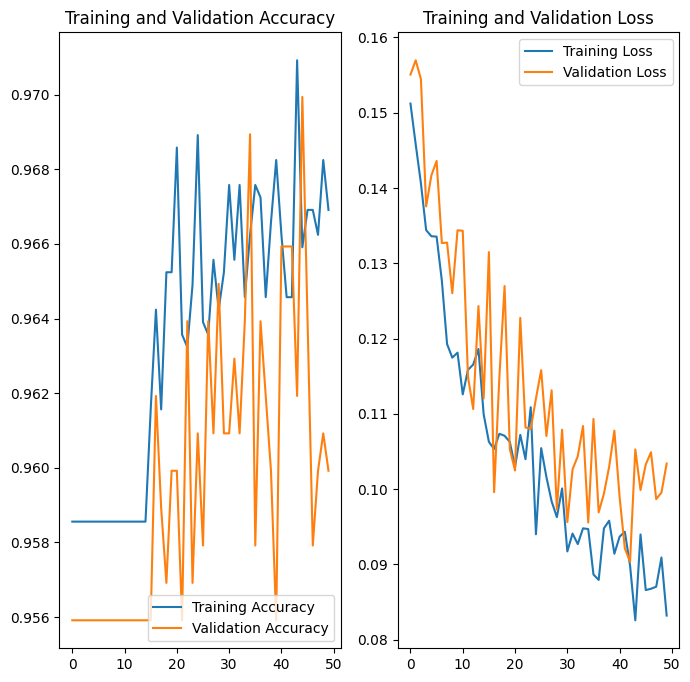

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [24]:
model.save('./cnn_50_epoch_size50')

INFO:tensorflow:Assets written to: ./cnn_50_epoch_size50\assets


INFO:tensorflow:Assets written to: ./cnn_50_epoch_size50\assets


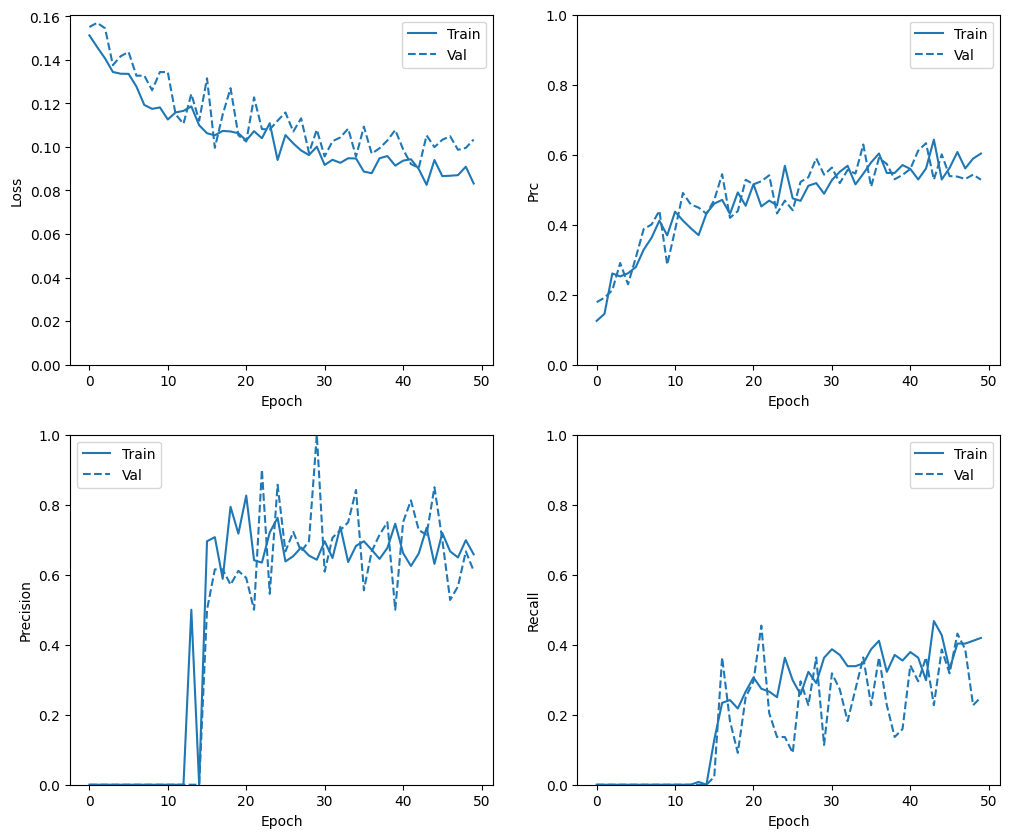

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)
